# Tabular synthetic data 
### A generation example with **Clearbox Synthetic Kit**

This notebook walks you through the tabular synthetic data generation process with **Clearbox Synthetic Kit**.

You can run this notebook on Google Colab or on your local machine.<br> 
In the second case, we highly recommend to create a dedicated virtual environment.

<div class="alert alert-secondary">
To run this notebook, make sure you change the runtime to <strong>GPU</strong><br>
<hr>
<strong>Runtime</strong> --> <strong>Change Runtime Type</strong> <br>
and set <strong>Hardware Accelerator</strong> to "<strong>GPU</strong>"
</div>

In [1]:
# Install the library
#%pip install clearbox-synthetic-kit

In [2]:
# Import necessary dependencies
import os

from clearbox_synthetic.utils import Dataset
from clearbox_synthetic.generation import TabularEngine

## 0. Data import

In [3]:
# Load the example datasets from GitHub

file_path = "https://raw.githubusercontent.com/Clearbox-AI/clearbox-synthetic-kit/main/tests/resources/uci_adult_dataset"

train_dataset = Dataset.from_csv(
        os.path.join(file_path, "dataset.csv"),
        target_column="income",
    )

## 1. Synthetic Data Generation

In [4]:
# Initialize the tabular synthetic data generator
engine = TabularEngine(train_dataset)

# Start the training of the tabular synthetic data generator
engine.fit(train_dataset, epochs=50, learning_rate=0.001)

No GPU detected. JAX is set to CPU mode.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/clearbox_preprocessor/preprocessor.py:328: UserWarning: Some rare labels have been aggregated into the 'other' category.
Note: you can view the discarded labels using the 'discarded' attribute of your Preprocessor class.
If certain labels were unintentionally discarded, try adjusting the 'cat_labels_threshold' parameter, but keep in mind that rare labels are at risk of being re-identified in case of privacy attack.

  warnings.warn(f"Some rare labels have been aggregated into the 'other' category.\nNote: you can view the discarded labels using the 'discarded' attribute of your Preprocessor class.\nIf certain labels were unintentionally discarded, try adjusting the 'cat_labels_threshold' parameter, but keep in mind that rare labels are at risk of being re-identified in case of privacy attack.\n")
Engine fitting in progress: 100%|██████████| 50/50 [00:08<00:00,  5.93epoch/s, Train loss:=0.5025528]


In [5]:
# Generate the syntehtic dataset from the Synthesizer
synthetic_df = engine.generate(train_dataset, n_samples=1000)
synthetic_df

,age,capital_gain,capital_loss,hours_per_week,sex,race,marital_status,work_class,native_country,occupation,relationship,education,income
0,45,0,0,40,Male,White,Married-civ-spouse,State-gov,United-States,Craft-repair,Husband,HS-grad,<=50K
1,40,0,0,40,Female,White,Divorced,Private,United-States,Craft-repair,Unmarried,Assoc-voc,<=50K
2,33,0,0,60,Male,White,Married-civ-spouse,Self-emp-not-inc,United-States,Prof-specialty,Husband,other,>50K
3,38,4531,0,40,Male,White,Married-civ-spouse,Private,United-States,Transport-moving,Husband,Bachelors,<=50K
4,41,0,0,35,Male,White,other,Private,other,Farming-fishing,Not-in-family,other,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,38,0,0,24,Male,White,Married-civ-spouse,None,United-States,None,Husband,HS-grad,<=50K
996,22,0,0,15,Male,White,Never-married,None,United-States,None,Not-in-family,Some-college,<=50K
997,35,0,0,55,Male,White,Married-civ-spouse,Private,United-States,Exec-managerial,Husband,Bachelors,>50K
998,32,0,0,40,Female,White,Widowed,Private,United-States,Prof-specialty,Unmarried,Bachelors,<=50K


# 2. Compare the results

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_column_distributions(
        df1, 
        columns, 
        df2=None, 
        df3=None, 
        df1_label="DF1", 
        df2_label="DF2", 
        df3_label="DF3", 
        bins=100, 
        kde=True, 
        x_min=None, 
        x_max=None, 
        normalization=False,
    ):
    if normalization:
        stat = "density"
        norm = " (normalized)"
    else:
        stat = "count"
        norm = ""

    if isinstance(columns,str):
        columns = [columns]
        
    n_cols = len(columns)
    fig, axes = plt.subplots(n_cols, 1, figsize=(10, 5 * n_cols), constrained_layout=True)

    # Ensure axes is always a list (even if only 1 column)
    if n_cols == 1:
        axes = [axes]

    for i, column in enumerate(columns):
        ax = axes[i]

        # Handle missing values
        df1_ = df1.copy()
        df1_[column] = df1_[column].fillna("None")
        if df2 is not None:
            df2_ = df2.copy()
            df2_[column] = df2_[column].fillna("None")
        if df3 is not None:
            df3_ = df3.copy()
            df3_[column] = df3_[column].fillna("None")

        # Plot histograms
        sns.histplot(df1_[column], bins=bins, kde=kde, color="blue", alpha=0.4, label=df1_label, stat=stat, ax=ax)
        if df2 is not None:
            sns.histplot(df2_[column], bins=bins, kde=kde, color="red", alpha=0.4, label=df2_label, stat=stat, ax=ax)
        if df3 is not None:
            sns.histplot(df3_[column], bins=bins, kde=kde, color="green", alpha=0.4, label=df3_label, stat=stat, ax=ax)

        # Axis labels and formatting
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.set_title(f"Comparison of {column} distributions{norm}")
        ax.legend()
        ax.grid(True)

        if x_min is not None and x_max is not None:
            ax.set_xlim([x_min, x_max])

        if column in engine.preprocessor.categorical_features:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.show()


In [7]:
print("Enter one of the following columns in the next code block to compare the original-synthetic data distributions:")
train_dataset.columns()

Enter one of the following columns in the next code block to compare the original-synthetic data distributions:


['age',
 'work_class',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income']

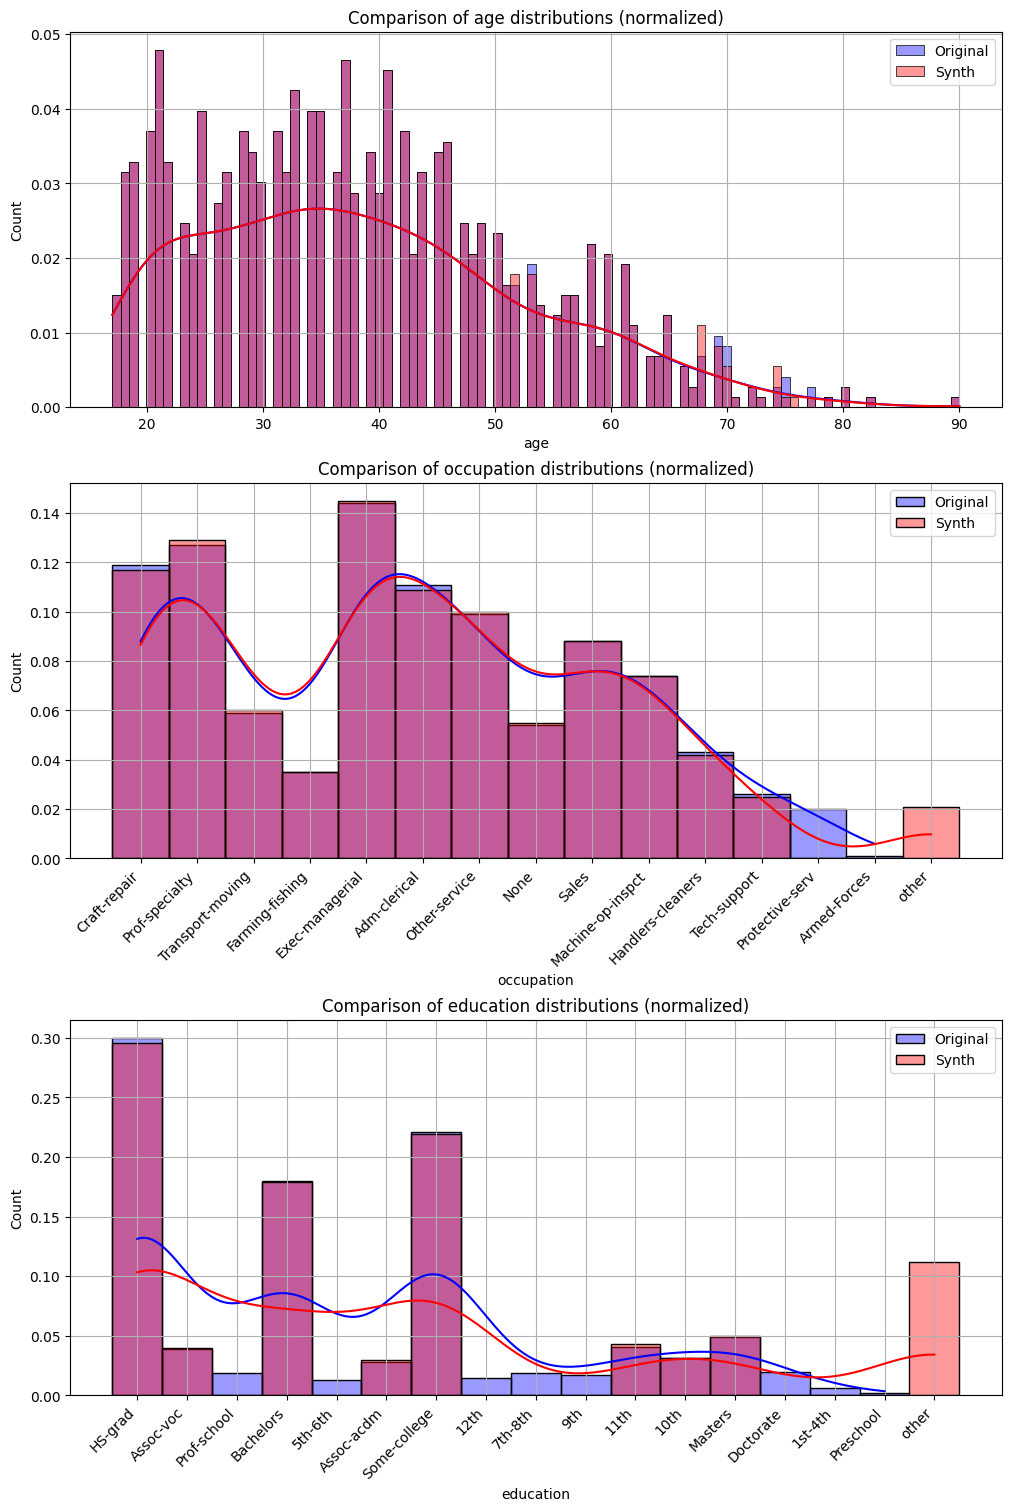

In [8]:
col = ["age", "occupation", "education"]

plot_column_distributions(
    train_dataset.data, 
    col, 
    synthetic_df, 
    df1_label="Original", 
    df2_label="Synth",
    bins=100,
    normalization=True)